In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import CLIP models

In [2]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4un28kfh
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-4un28kfh
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=3e709669ee49455898693888d38a7f5e270fdea5dfa93e13da46cfd34b2d10c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-ou4f63yh/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [3]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 1.12.1+cu113


In [4]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

# Load image data

In [5]:
import time
import os 
#Set path according to your situation
image_dir = os.getcwd() + '/drive/MyDrive/PytorchNeuralStyleTransfer-master/Images/'


import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict
from pylab import *

In [6]:
# Select device to work on.
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = torch.device("cpu") #if use gpu, loss will be nan. Not sure what's going on, but it works using cpu

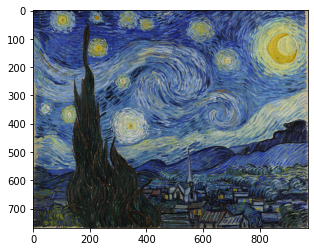

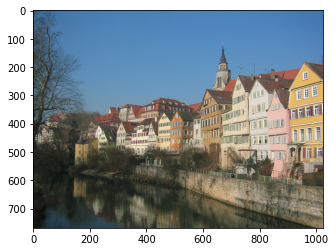

In [8]:
##### load images, ordered as [style_image, content_image]
img_dirs = [image_dir, image_dir]
img_names = ['vangogh_starry_night.jpg', 'Tuebingen_Neckarfront.jpg']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]

for img in imgs:
  imshow(img);show()

# Load RN50 from CLIP

In [9]:
import clip
model_rn50, preprocess_rn50 = clip.load('RN50', device=device)
for param in model_rn50.parameters():
    param.requires_grad = False

100%|███████████████████████████████████████| 244M/244M [00:04<00:00, 60.0MiB/s]


In [10]:
model_rn50

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [11]:
preprocess_rn50

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f456dd34710>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [12]:
model_rn50 = model_rn50.visual

In [13]:
model_rn50

ModifiedResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), str

# Preprocess the image data

In [14]:
prep = transforms.Compose([transforms.Resize(size=224, max_size=None, antialias=None),
                           transforms.CenterCrop(size=(224, 224)),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul(255)),
                          ])

postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [15]:
##### load images, ordered as [style_image, content_image]
imgs_torch = [prep(img) for img in imgs]

if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

opt_img = Variable(content_image.data.clone(), requires_grad=True)

# Define gram matrix and loss

In [16]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        #b=batch, c=channel, h=height, w=weight
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        #等价于表达式：
        #loss = nn.MSELoss()
        #output = loss(input, target)
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

# Extract feature maps from RN50

In [17]:
style_activations = {}
content_activations = {}
opt_activations = {}
def getActivation(name):
  def hook(model, input, output):
    style_activations[name] = output.detach()
    content_activations[name] = output.detach()
    opt_activations[name] = output
  return hook

In [18]:
h0 = model_rn50.conv1.register_forward_hook(getActivation('conv1'))
h1 = model_rn50.bn1.register_forward_hook(getActivation('bn1'))
h2 = model_rn50.relu1.register_forward_hook(getActivation('relu1'))
h3 = model_rn50.conv2.register_forward_hook(getActivation('conv2'))
h4 = model_rn50.bn2.register_forward_hook(getActivation('bn2'))
h5 = model_rn50.relu2.register_forward_hook(getActivation('relu2'))
h6 = model_rn50.conv3.register_forward_hook(getActivation('conv3'))
h7 = model_rn50.bn3.register_forward_hook(getActivation('bn3'))
h8 = model_rn50.relu3.register_forward_hook(getActivation('relu3'))
h9 = model_rn50.avgpool.register_forward_hook(getActivation('avgpool'))

L1_Bottleneck_0 = model_rn50.layer1[0].register_forward_hook(getActivation('L1_Bottleneck_0'))
L1_Bottleneck_1 = model_rn50.layer1[1].register_forward_hook(getActivation('L1_Bottleneck_1'))
L1_Bottleneck_2 = model_rn50.layer1[2].register_forward_hook(getActivation('L1_Bottleneck_2'))


L2_Bottleneck_0 = model_rn50.layer2[0].register_forward_hook(getActivation('L2_Bottleneck_0'))
L2_Bottleneck_1 = model_rn50.layer2[1].register_forward_hook(getActivation('L2_Bottleneck_1'))
L2_Bottleneck_2 = model_rn50.layer2[2].register_forward_hook(getActivation('L2_Bottleneck_2'))
L2_Bottleneck_3 = model_rn50.layer2[3].register_forward_hook(getActivation('L2_Bottleneck_3'))


L3_Bottleneck_0 = model_rn50.layer3[0].register_forward_hook(getActivation('L3_Bottleneck_0'))
L3_Bottleneck_1 = model_rn50.layer3[1].register_forward_hook(getActivation('L3_Bottleneck_1'))
L3_Bottleneck_2 = model_rn50.layer3[2].register_forward_hook(getActivation('L3_Bottleneck_2'))
L3_Bottleneck_3 = model_rn50.layer3[3].register_forward_hook(getActivation('L3_Bottleneck_3'))
L3_Bottleneck_4 = model_rn50.layer3[4].register_forward_hook(getActivation('L3_Bottleneck_4'))
L3_Bottleneck_5 = model_rn50.layer3[5].register_forward_hook(getActivation('L3_Bottleneck_5'))


L4_Bottleneck_0 = model_rn50.layer4[0].register_forward_hook(getActivation('L4_Bottleneck_0'))
L4_Bottleneck_1 = model_rn50.layer4[1].register_forward_hook(getActivation('L4_Bottleneck_1'))
L4_Bottleneck_2 = model_rn50.layer4[2].register_forward_hook(getActivation('L4_Bottleneck_2'))

# Define layers, loss functions, weights and compute optimization targets

In [19]:
#define layers, loss functions, weights and compute optimization targets

style_layers = ['relu1', 'relu2', 'relu3', 'L1_Bottleneck_0', 'L1_Bottleneck_1']
content_layers = ['L1_Bottleneck_0']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]

#weights settings
style_weights = [1e3/n**2 for n in [32, 32, 64, 256, 256]]
content_weights = [1e0]
weights = style_weights + content_weights

#get activation outputs
style_result = model_rn50(style_image)
style_activations_list = []
for i, (k, v) in enumerate(style_activations.items()):
  if k in style_layers:
    style_activations_list.append(v)

content_result = model_rn50(content_image)
content_activations_list = []
for i, (k, v) in enumerate(content_activations.items()):
  if k in content_layers:
    content_activations_list.append(v)

#output style and content feature maps' shape
print('Feature Maps of style image:')
for i in range(len(style_activations_list)):
  print(f"Layer {i}:", style_activations_list[i].shape)

print('Feature Maps of content image:')
for i in range(len(content_activations_list)):
  print(f"Layer {i}:", content_activations_list[i].shape)

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in style_activations_list]
content_targets = [A.detach() for A in content_activations_list]
targets = style_targets + content_targets

Feature Maps of style image:
Layer 0: torch.Size([1, 32, 112, 112])
Layer 1: torch.Size([1, 32, 112, 112])
Layer 2: torch.Size([1, 64, 112, 112])
Layer 3: torch.Size([1, 256, 56, 56])
Layer 4: torch.Size([1, 256, 56, 56])
Feature Maps of content image:
Layer 0: torch.Size([1, 256, 56, 56])


In [20]:
#opt_img = Variable(content_image.data.clone(), requires_grad=True)
out_img_result = model_rn50(opt_img)
opt_activations_list = []
for i, (k, v) in enumerate(opt_activations.items()):
  if k in style_layers:
    opt_activations_list.append(v)
for i, (k, v) in enumerate(opt_activations.items()):
  if k in content_layers:
    opt_activations_list.append(v)
  

layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(opt_activations_list)]
layer_losses

[tensor(61895.7344, grad_fn=<MulBackward0>),
 tensor(93077.7734, grad_fn=<MulBackward0>),
 tensor(21360.2676, grad_fn=<MulBackward0>),
 tensor(1171.8116, grad_fn=<MulBackward0>),
 tensor(1250.8007, grad_fn=<MulBackward0>),
 tensor(0., grad_fn=<MulBackward0>)]

# Run style transfer

Iteration: 50, loss: 358.506042
Iteration: 100, loss: 178.601807
Iteration: 150, loss: 144.055191
Iteration: 200, loss: 128.460098
Iteration: 250, loss: 118.917671
Iteration: 300, loss: 111.962753
Iteration: 350, loss: 106.257530
Iteration: 400, loss: 101.172592
Iteration: 450, loss: 96.557556
Iteration: 500, loss: 92.626030


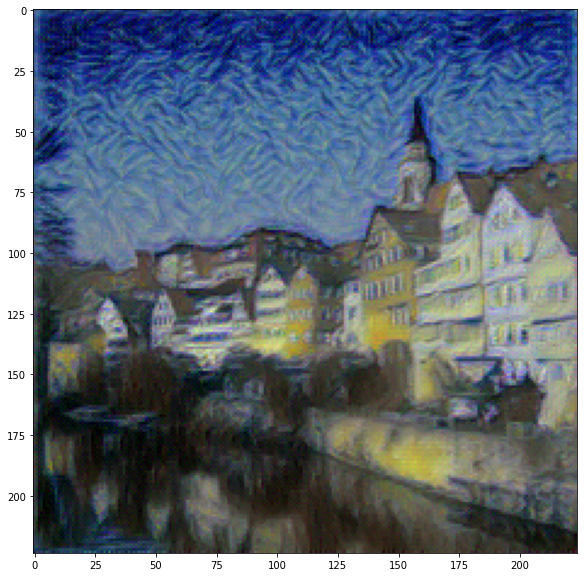

In [21]:
#run style transfer
max_iter = 500
show_iter = 50

optimizer = optim.LBFGS([opt_img]);
n_iter=[0]
loss_list = []

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = model_rn50(opt_img)
        opt_activations_list = []
        for i, (k, v) in enumerate(opt_activations.items()):
          if k in style_layers:
            opt_activations_list.append(v)
        for i, (k, v) in enumerate(opt_activations.items()):
          if k in content_layers:
            opt_activations_list.append(v)

        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(opt_activations_list)]
        
        loss = 0
        for layer_loss in layer_losses:
          loss = loss + layer_loss
        loss.backward()
        loss_list.append(loss.item())
        n_iter[0]+=1
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
        return loss
    
    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

In [ ]:
!cat /proc/cpuinfo | grep model\ name

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


# Appendix

## Visualize feature maps of content image and style image using RN50

In [ ]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
# outputs_rn50_content = model_rn50.visual(opt_img)

for num_layer in range(len(content_activations_list)):
    plt.figure(figsize=(30, 30)) 
    # print(outputs_rn50_content[num_layer].shape)
    layer_viz = content_activations_list[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 32: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(4, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    print(f"Loading layer {num_layer} feature maps...")
    
    plt.show()
    plt.close()

In [ ]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
# outputs_rn50_style = model_rn50.visual(opt_img)
for num_layer in range(len(style_activations_list)):
    plt.figure(figsize=(30, 30)) 
    layer_viz = style_activations_list[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 32: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(4, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    print(f"Loading layer {num_layer} feature maps...")
    
    plt.show()
    plt.close()

## Visualize feature maps of content image and style image using VGG

In [ ]:
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        
        return [out[key] for key in out_keys]

In [ ]:
model_dir = os.getcwd() + '/drive/MyDrive/Colab Notebooks/PytorchNeuralStyleTransfer-master/Models/'

#get network
vgg = VGG()

vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [ ]:
vgg_layers = ['r11', 'r12', 'r21', 'r22', 'r31', 'r32', 'r33', 'r34', 'r41', 'r42', 
              'r43', 'r44', 'r51', 'r52', 'r53', 'r54']

In [ ]:
#visualize content output
outputs_vgg_content = vgg(content_image, vgg_layers)

for num_layer in range(len(outputs_vgg_content)):
    plt.figure(figsize=(30, 30)) 
    layer_viz = outputs_vgg_content[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 32: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(4, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    print(f"Loading layer {num_layer} feature maps...")
    
    plt.show()
    plt.close()

In [ ]:
#visualize style output
outputs_vgg_style = vgg(style_image, vgg_layers)

for num_layer in range(len(outputs_vgg_style)):
    plt.figure(figsize=(30, 30)) 
    layer_viz = outputs_vgg_style[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 32: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(4, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    print(f"Loading layer {num_layer} feature maps...")
    
    plt.show()
    plt.close()